### IS4242 Group 8 Project

### Exploratory Data Analysis

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

In [6]:
# Constants

TARGET_VARS = ["hate", "privacy", "sexual", "impersonation", "illegal", "advertisement", "ai"]
RANDOM_STATE = 42

### Exploring the processed dataset

In [5]:
df = pd.read_csv('data/df_combined_processed_2023-03-30.csv')
df

,body,hate,privacy,sexual,impersonation,illegal,advertisement,ai
0,career career kalleron design refus collect re...,0,0,0,0,0,0,0
1,career career hotmeringue2880 hi econom gradua...,0,0,0,0,0,0,0
2,career career milenakowalska hey year finish b...,0,0,0,0,0,0,0
3,career career rstonerphd studi make employe wa...,0,0,0,0,0,1,0
4,career career temporarysection50 hi accept job...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
41198,you muthafin lie 8220lifeask 20pearl coreyeman...,1,0,0,0,0,0,0
41199,youv gone broke wrong heart babi drove redneck...,0,0,0,0,0,0,0
41200,young buck wanna eat dat nigguh like aint fuck...,1,0,0,0,0,0,0
41201,youu got wild bitch tellin lie,1,0,0,0,0,0,0


### Target Class Exploration

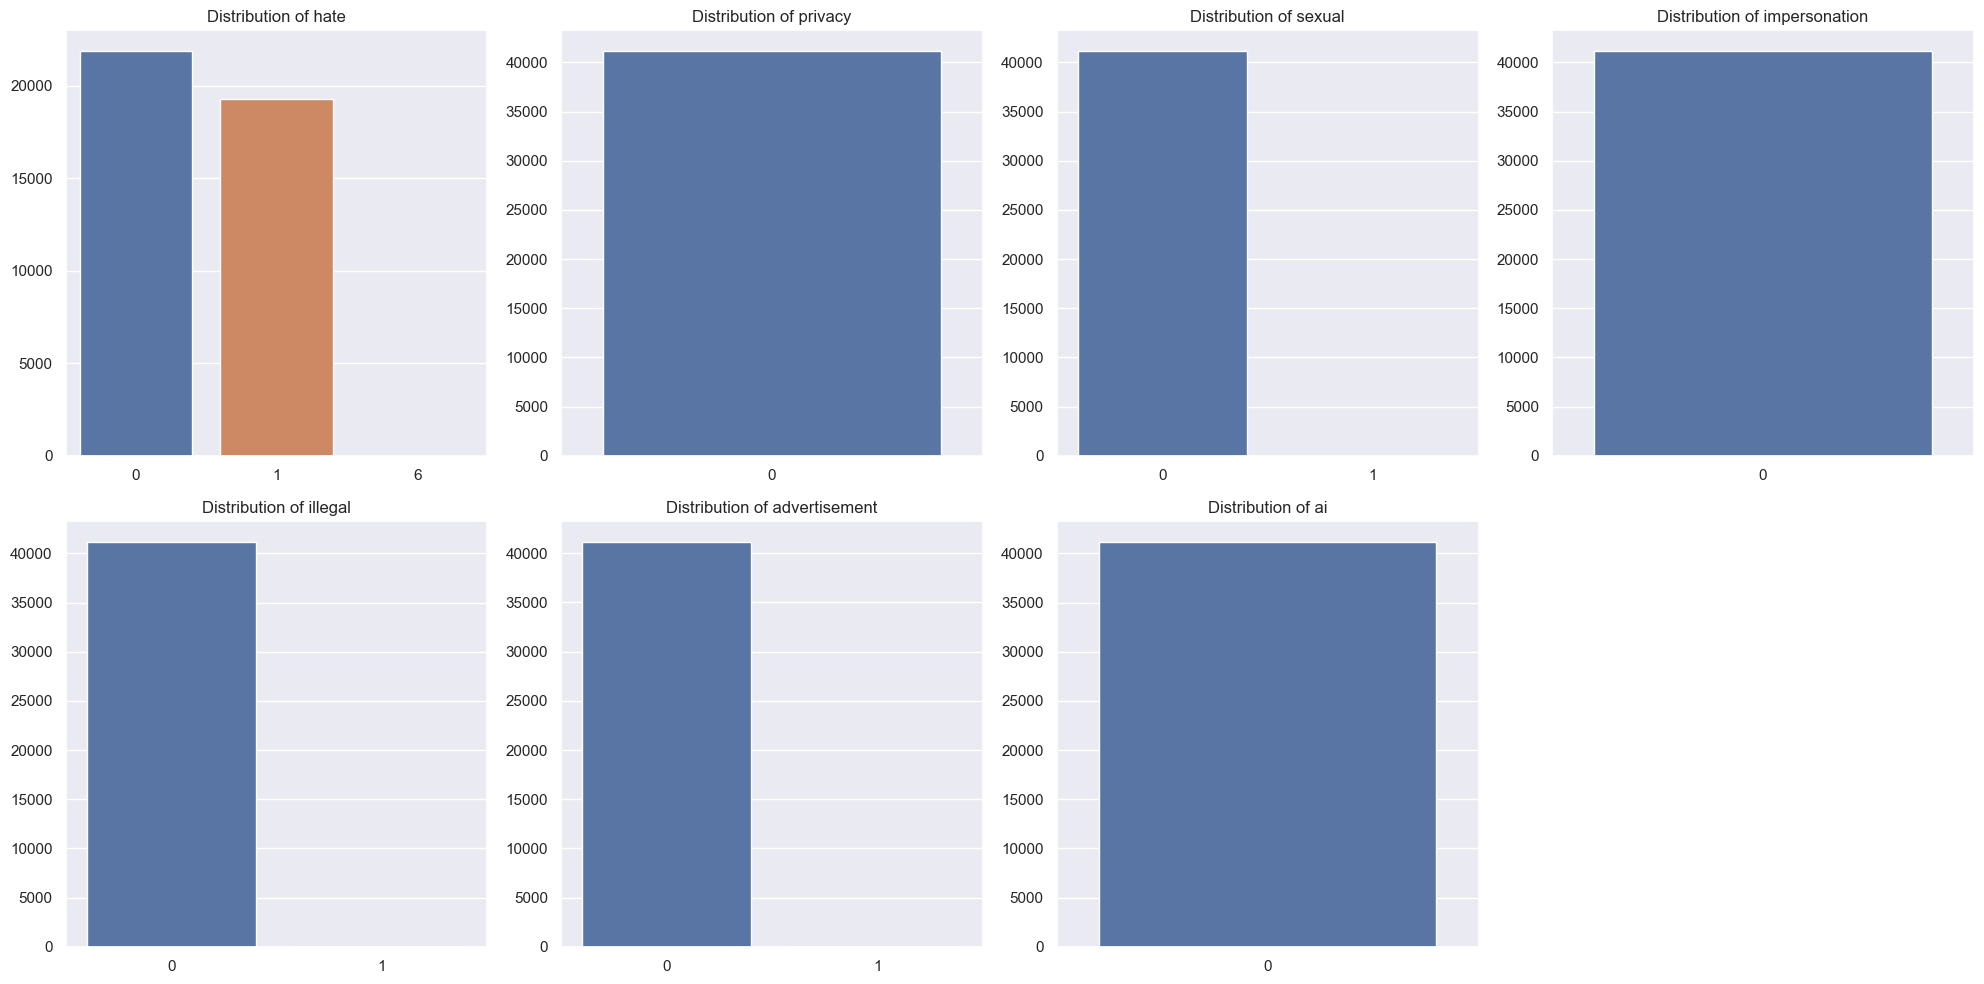

In [18]:
# Plotting the distribution of the target variables

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    if i < 7:
        sns.countplot(data=df, x=TARGET_VARS[i], ax=ax)
        ax.set_title(f'Distribution of {TARGET_VARS[i]}')
        ax.set_xlabel('')
        ax.set_ylabel('')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()